# Arrival Delays in Atlanta Flights
### by Micah Costello

In this project, I'll be analyzing flight data for a sample of domestic flights to and from Atlanta, Georgia (airport code ATL), from 1987 through 2008. 

The data comes from a zip file from the website https://community.amstat.org/jointscsg-section/dataexpo/dataexpo2009. As the data comes as a collection of csv files for *all* domestic flights for each year, I will have to perform some preliminary gathering to get a sample of the ATL flights. 

# Data Gathering
Since there are so many flights to consider, I'll only take a sample of 20,000 flights per year, for a total of 440,000 flights before data cleaning.

In [1]:
# import libraries I'm sure to use
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
# empty df to append to
df = pd.DataFrame()

# loop through files in directory that are flight years
for flight_year in glob.glob('DataExpo2009/*.csv.bz2'):
    temp_df = pd.read_csv(flight_year, encoding = 'latin-1') # make df for flight year
    atl_flights = temp_df[(temp_df.Origin == 'ATL') | # make df of all flights for flight year from/to ATL 
                              (temp_df.Dest == 'ATL')]
    df = df.append(atl_flights.sample(20000)) # append sample to empty df
    print(str(atl_flights.Year.unique()[0]) + ' appending complete')

In [3]:
df.to_csv('combined_atl_flights.csv', index = False)

# Assessment
Now I'll assess the data I've just gathered, to check for any issues that may need to be cleaned. 

In [4]:
# read csv to frame
df = pd.read_csv('combined_atl_flights.csv', dtype = {'TailNum': 'object', 'CancellationCode': 'object'} )

In [5]:
# take a look at dataset structure, NaNs and first few rows
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440000 entries, 0 to 439999
Data columns (total 29 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Year               440000 non-null  int64  
 1   Month              440000 non-null  int64  
 2   DayofMonth         440000 non-null  int64  
 3   DayOfWeek          440000 non-null  int64  
 4   DepTime            432244 non-null  float64
 5   CRSDepTime         440000 non-null  int64  
 6   ArrTime            431393 non-null  float64
 7   CRSArrTime         440000 non-null  int64  
 8   UniqueCarrier      440000 non-null  object 
 9   FlightNum          440000 non-null  int64  
 10  TailNum            279927 non-null  object 
 11  ActualElapsedTime  431384 non-null  float64
 12  CRSElapsedTime     439969 non-null  float64
 13  AirTime            273693 non-null  float64
 14  ArrDelay           431384 non-null  float64
 15  DepDelay           432244 non-null  float64
 16  Or

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,1991,9,19,4,1026.0,1027,1242.0,1220,DL,1076,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,1991,5,6,1,1323.0,1319,1535.0,1530,DL,978,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,1991,1,20,7,755.0,750,1225.0,1229,DL,402,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,1991,3,25,1,1005.0,1000,1104.0,1107,DL,1045,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,1991,12,9,1,2214.0,2215,2323.0,2317,DL,585,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN


I see the following problems from initial assessment:
* All column names are capitalized: this is cumbersome
* Some flights may be cancelled or diverted: investigation below
* Needs date column
* Data is not organized by date
* 'month' column could be month names like "January" instead of int, also ordered categorical dtype
* 'dayofweek' column could be names instead of int, also ordered categorical dtype
* The time columns are integers and floats, should be datetime in proper format
* from `.info()` I see that all the delay columns except arrival and departure have the same amount of non-null values. Investigation below.

### Cancelled or Diverted flights
I'll check to see if any flights were cancelled or diverted. 

In [6]:
# get number of cancelled/delayed flights
df[(df.Cancelled == 1) | (df.Diverted == 1)].shape[0]

8616

A significant amount of flights were cancelled or diverted. I will want to remove these flights before analysis. Added to cleaning list.

### Delay columns all have same amount of Non-null values
I'll take a quick look at one of the columns to see if it illuminates me. 

In [7]:
# see some rows where carrier delay is not null
df[~df.CarrierDelay.isnull()]

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
20000,2004,7,24,6,734.0,740,907.0,908,DL,920,...,8.0,15.0,0,NaN,0,0.0,0.0,0.0,0.0,0.0
20001,2004,10,10,7,812.0,804,805.0,757,OH,5479,...,4.0,17.0,0,NaN,0,0.0,0.0,0.0,0.0,0.0
20002,2004,11,25,4,1029.0,955,1040.0,1012,DL,1011,...,8.0,20.0,0,NaN,0,0.0,0.0,0.0,0.0,28.0
20003,2004,12,15,3,849.0,849,1017.0,1017,EV,4682,...,3.0,26.0,0,NaN,0,0.0,0.0,0.0,0.0,0.0
20004,2004,10,28,4,2106.0,1956,2211.0,2054,DL,1869,...,8.0,14.0,0,NaN,0,0.0,0.0,77.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399955,2008,4,23,3,1909.0,1906,2058.0,2040,FL,414,...,28.0,8.0,0,NaN,0,0.0,0.0,15.0,0.0,3.0
399966,2008,2,14,4,1643.0,1606,1855.0,1830,EV,4846,...,2.0,16.0,0,NaN,0,25.0,0.0,0.0,0.0,0.0
399975,2008,8,27,3,1558.0,1600,1926.0,1911,OO,4030,...,16.0,11.0,0,NaN,0,0.0,0.0,15.0,0.0,0.0
399984,2008,11,24,1,557.0,600,910.0,839,DL,405,...,21.0,20.0,0,NaN,0,0.0,0.0,31.0,0.0,0.0


It seems that in some cases, certain types of delay are marked as 0 instead of NaN if they didn't occur. Also it is interesting that the year column starts in 2004 instead of 1991 as it did in the original `.head()`function. I'll check the years for which the delay columns are not null.

In [8]:
# make list of delay columns w/o departure or arrival
delay_cols = ['CarrierDelay','WeatherDelay','SecurityDelay','NASDelay','LateAircraftDelay']

# print year values for when these columns are not null
for col in delay_cols:
    print(df[~df[col].isnull()].Year.unique())

[2004 2005 2007 2006 2003 2008]
[2004 2005 2007 2006 2003 2008]
[2004 2005 2007 2006 2003 2008]
[2004 2005 2007 2006 2003 2008]
[2004 2005 2007 2006 2003 2008]


The delay columns are only non-null for 2004 and up. There is nothing I can do about this. However, I should set delay column values of 0 to NaN. Having loads of unnecessary 0 values could distort statistical analysis. Added to cleaning list.

## Continue Assessment with statistical summary

I'll now continue assessment by looking for strange values in the statistical description of the dataset. 

In [9]:
# assessment of statistics, check for strange numbers
# divide .describe() into two sections to avoid truncation
print(df.iloc[:,:20].describe())
print(df.iloc[:,20:].describe())


                Year          Month     DayofMonth      DayOfWeek  \
count  440000.000000  440000.000000  440000.000000  440000.000000   
mean     1997.500000       6.731473      15.727270       3.970886   
std         6.344296       3.497252       8.781897       1.996014   
min      1987.000000       1.000000       1.000000       1.000000   
25%      1992.000000       4.000000       8.000000       2.000000   
50%      1997.500000       7.000000      16.000000       4.000000   
75%      2003.000000      10.000000      23.000000       6.000000   
max      2008.000000      12.000000      31.000000       7.000000   

             DepTime     CRSDepTime        ArrTime     CRSArrTime  \
count  432244.000000  440000.000000  431393.000000  440000.000000   
mean     1374.640784    1366.191393    1495.800544    1497.069361   
std       489.413176     480.843145     512.464954     497.984236   
min         1.000000       0.000000       1.000000       0.000000   
25%       956.000000     954.0000

From the above I see:
* Some of the time columns have strange numbers, like 5. I believe this is 00:05 but as a float/int type. Also, some time columns have a max value abouve 23:59. When I convert these numbers to datetime, this will be a problem. Added to cleaning list.
* columns `TaxiIn`and `TaxiOut` have some absurdly high values as maximums. Also, `AirTime`has a negative minimum. Investigation below.
* The minimum for arrdelay is - 813 minutes. A negative number means early arrival, but I doubt that a flight would've arrived almost 14 hours early. Investigation below.

### Taxi columns

In [10]:
# begin by taking a look at taxiin max
taxiin_max_inx = df.TaxiIn.argmax() # get index of max value
df.iloc[taxiin_max_inx] # show row for max value

Year                   2005
Month                     4
DayofMonth                4
DayOfWeek                 1
DepTime              2239.0
CRSDepTime             2239
ArrTime              2429.0
CRSArrTime               29
UniqueCarrier            EV
FlightNum              4274
TailNum              N929EV
ActualElapsedTime     110.0
CRSElapsedTime        110.0
AirTime             -1359.0
ArrDelay                0.0
DepDelay                0.0
Origin                  ATL
Dest                    DTW
Distance              594.0
TaxiIn               1458.0
TaxiOut                11.0
Cancelled                 0
CancellationCode        NaN
Diverted                  0
CarrierDelay            0.0
WeatherDelay            0.0
NASDelay                0.0
SecurityDelay           0.0
LateAircraftDelay       0.0
Name: 141246, dtype: object

 In this case, at least, the long taxi in is rectified by a negative value for airtime. I think this is some sort of data entry error. This is probably the case for the taxi out column as well. The rest of the row seems correct, aside from the incorrect time. Below, I'll see how many air time values are negative, and how many taxi values are greater than 2 hours. More than 2 hours taxiing seems incredibly unlikely, and I think I'm being lenient with such a high number. 

In [11]:
# see number of improbable/impossible values for taxi and airtime columns
print(df[df.AirTime < 0].shape[0])
print(df[df.TaxiIn > 120].shape[0])
print(df[df.TaxiOut > 120].shape[0])

383
401
247


There are very few rows like this. Because there are so many variables at play( origin, destination, departure time...) I don't want to replace the values with mean. I'll get their indexes and set them as null in the cleaning section. Added to cleaning list.

### Arrdelay Minimum

In [12]:
# take a look at some of the lowest arrdelay values
df.ArrDelay.nsmallest(10)

289711   -813.0
4981     -702.0
297638   -688.0
173510   -132.0
85346     -76.0
148096    -68.0
241704    -65.0
327469    -60.0
401566    -56.0
102695    -54.0
Name: ArrDelay, dtype: float64

There are very few values that are absurdly negative. I think if a flight had a lot of luck, it could arrive 1 hour early to one of the far-away destinations, like Hawaii. I'm going to drop rows where the arrdelay is less than - 60 minutes. Added to cleaning list.

## Cleaning List
1. All column names are capitalized: this is cumbersome
2. Some flights are cancelled or diverted: need to be removed
3. Drop rows with extreme negative arrdelay values
4. Needs a date column
5. Data is not organized by date
6. Month column could be month names like "January" instead of int, also ordered categorical dtype
7. Dayofweek column could be names instead of int, also ordered categorical dtype
8. The time columns are integers and floats, should be datetime in proper format
9. Replace impossible/improbable taxi and airtime values with np.nan
10. Replace delay column values of 0 with np.nan( except departure delay and arrival delay)
11. Drop extraneous cancelled/diverted columns

# Data Cleaning

In [13]:
# make copy of df for cleaning
df_copy = df.copy()

## 1. Capitalized Column Names
### Define
Map a function to columns names to make all letters in the string lower case.

### Code

In [14]:
df_copy.rename(str.lower, axis = 1, inplace = True)

### Test

In [15]:
# should return list of lower case column names
df_copy.columns

Index(['year', 'month', 'dayofmonth', 'dayofweek', 'deptime', 'crsdeptime',
       'arrtime', 'crsarrtime', 'uniquecarrier', 'flightnum', 'tailnum',
       'actualelapsedtime', 'crselapsedtime', 'airtime', 'arrdelay',
       'depdelay', 'origin', 'dest', 'distance', 'taxiin', 'taxiout',
       'cancelled', 'cancellationcode', 'diverted', 'carrierdelay',
       'weatherdelay', 'nasdelay', 'securitydelay', 'lateaircraftdelay'],
      dtype='object')

## 2. Remove Cancelled/Diverted flights
### Define
I will pull the index of all cancelled and diverted flights and drop them.
### Code

In [16]:
# get index of cancelled or diverted flights
cancel_divert_indexes = df_copy[(df_copy['cancelled'] == 1) | (df_copy.diverted == 1)].index
# drop
df_copy.drop(cancel_divert_indexes, axis = 0, inplace = True)

### Test

In [17]:
# should return empty frame 
df_copy[(df_copy.cancelled == 1) | (df_copy.diverted == 1)]

,year,month,dayofmonth,dayofweek,deptime,crsdeptime,arrtime,crsarrtime,uniquecarrier,flightnum,...,taxiin,taxiout,cancelled,cancellationcode,diverted,carrierdelay,weatherdelay,nasdelay,securitydelay,lateaircraftdelay


## 3. Drop rows with extreme negative arrdelay values
### Define
I will pull the index of all arrdelay values lower than -60 and drop them.

In [18]:
# get index of rows with arrdelay less than - 60
low_arrdelay_vals = df_copy[df_copy.arrdelay < -60].index
# drop
df_copy.drop(low_arrdelay_vals, axis = 0, inplace = True)

### Test

In [19]:
# should return empty dataframe
df_copy[df_copy.arrdelay < -60]

,year,month,dayofmonth,dayofweek,deptime,crsdeptime,arrtime,crsarrtime,uniquecarrier,flightnum,...,taxiin,taxiout,cancelled,cancellationcode,diverted,carrierdelay,weatherdelay,nasdelay,securitydelay,lateaircraftdelay


## 4. Needs Date Column
### Define
Create "date" column by concatenating columns "year","month" and "dayofmonth" as strings, then coverting to datetime.

### Code

In [20]:
# concatenate year, month and dayofmonth columns as string and convert to datetime
df_copy['date'] = pd.to_datetime(df_copy['year'].astype('str') + ' ' + df_copy['month'].astype('str') +
                            ' ' + df_copy['dayofmonth'].astype('str'))

### Test

In [21]:
# date column should be last column of df, correspond to above concatenated columns
df_copy.head(3)

,year,month,dayofmonth,dayofweek,deptime,crsdeptime,arrtime,crsarrtime,uniquecarrier,flightnum,...,taxiout,cancelled,cancellationcode,diverted,carrierdelay,weatherdelay,nasdelay,securitydelay,lateaircraftdelay,date
0,1991,9,19,4,1026.0,1027,1242.0,1220,DL,1076,...,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,1991-09-19
1,1991,5,6,1,1323.0,1319,1535.0,1530,DL,978,...,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,1991-05-06
2,1991,1,20,7,755.0,750,1225.0,1229,DL,402,...,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,1991-01-20


## 5. Data Not Organized by Date
### Define
Sort values by newly created "date" column.
### Code

In [22]:
# sort df by date column
df_copy.sort_values('date',inplace = True)

### Test

In [23]:
# should start with October 1987 and en with December 2008
print(df_copy.date.head())
print(df_copy.date.tail())

285103   1987-10-01
288134   1987-10-01
299585   1987-10-01
288099   1987-10-01
299559   1987-10-01
Name: date, dtype: datetime64[ns]
381301   2008-12-31
398235   2008-12-31
382928   2008-12-31
389452   2008-12-31
380290   2008-12-31
Name: date, dtype: datetime64[ns]


In [24]:
# reset index after reordering
df_copy.reset_index(drop = True,inplace = True)

## 6. Month is Int Instead of Name
### Define
Use Python's calendar library to apply a lambda function to the `"month"` column. For month integer, return corresponding month name. 

I will wait to convert to categorical dtype. I want to save the cleaned df to a csv file. When I re-upload the cleaned data to a new dataframe, the column will need to be converted to categorical type again, so no need to do that here. 

### Code

In [25]:
import calendar

# for each value in month column get month name
df_copy['month'] = df_copy.month.apply(lambda x: calendar.month_name[x])

### Test

In [26]:
# should return list of month names
df_copy.month.unique()

array(['October', 'November', 'December', 'January', 'February', 'March',
       'April', 'May', 'June', 'July', 'August', 'September'],
      dtype=object)

## 7. Day of Week is int instead of name
### Define
Use Python's calendar library to apply a labmda function to the "dayofweek" column. For day integer, return corresponding day name. The `calendar.day_name` function works with Monday as index 0 and Sunday as index 6. So I'll first have to subtract 1 from each dayofweek value, so that it matches with the day_name index.

Just like month column, I will wait to convert the weekdays to categorical type
### Code

In [27]:
# subtract 1 from day of week value, use it to index calendar.day_name and return day name
df_copy['dayofweek'] = df_copy.dayofweek.apply(lambda x: calendar.day_name[x - 1])

### Test

In [28]:
# should return list of weekdays
df_copy.dayofweek.unique()

array(['Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday',
       'Wednesday'], dtype=object)

## 8. Correct Time Columns
### Define
Here I am going to correct the time columns by:
* subtracting 2400 from those values that are greater than 2400( necessary to convert to datetime
* add padding 0s to values that are less than 1000( datetimes `strptime`function won't accept values like 900 - needs to be 0900
* convert to datetime objects
* convert to time objects

I will acheive this by writing a function to perform the first two tasks to all of each delay column's values. Then loop through each column, convert to Int if float, then to object. Then run the function on the column, and finally, convert to a time object.
### Code

In [29]:
from datetime import datetime

# function to add padding 0 to times with length that is less than 4
def correct_time_cols(time):
    """ take a string. add zeros for padding if length is  less than 4."""     
    if int(time) > 2400:
        time = str(int(time) - 2400) # corrects columns where time is greater than 2400 ( after midnight)
    if len(time) == 3: # add padding 0 for strptime
        time = '0' + time
    elif len(time) == 2:
        time = '00' + time
    elif len(time) == 1:
        time = '000' + time
    try:
        correct_time = datetime.strptime(time,'%H%M') # convert string to datetime
        return correct_time
    except:
        return None # in the event of incorrect times

In [30]:
# get list of time columns
time_cols = ['deptime','crsdeptime','arrtime','crsarrtime']

# loop through list
for col in time_cols:
    df_copy[col] = df_copy[col].astype('Int64') # remove float .0 to later convert to string
    df_copy[col] = df_copy[col].astype('object') # convert to string
    df_copy[col] = df_copy[col].apply(lambda x: correct_time_cols(str(x))) # apply above function to convert to datetime
    df_copy[col] = df_copy[col].dt.time # convert to time

### Test

In [31]:
# time columns should now be date objects
df_copy.head()

,year,month,dayofmonth,dayofweek,deptime,crsdeptime,arrtime,crsarrtime,uniquecarrier,flightnum,...,taxiout,cancelled,cancellationcode,diverted,carrierdelay,weatherdelay,nasdelay,securitydelay,lateaircraftdelay,date
0,1987,October,1,Thursday,19:37:00,19:37:00,21:40:00,21:29:00,EA,734,...,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,1987-10-01
1,1987,October,1,Thursday,12:55:00,12:55:00,14:14:00,14:14:00,DL,461,...,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,1987-10-01
2,1987,October,1,Thursday,06:44:00,06:44:00,07:41:00,07:40:00,DL,521,...,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,1987-10-01
3,1987,October,1,Thursday,15:13:00,15:13:00,16:45:00,16:45:00,DL,378,...,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,1987-10-01
4,1987,October,1,Thursday,16:00:00,16:00:00,18:18:00,18:00:00,DL,1084,...,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,1987-10-01


## 9. Replace impossible/improbable taxi and airtime values with np.nan
### Define
I will query the rows where tax in and taxi out are greater than 120 minutes and where airtime is less than 0, and replace those values with np.nan. 
### Code

In [32]:
df_copy.loc[df_copy.taxiin > 120, 'taxiin'] = np.nan
df_copy.loc[df_copy.taxiout > 120, 'taxiout'] = np.nan
df_copy.loc[df_copy.airtime < 0, 'airtime'] = np.nan

### Test

In [33]:
# the descriptive statistics should have no surprising numbers
df_copy.describe()[['taxiin','taxiout','airtime']]

,taxiin,taxiout,airtime
count,273133.000000,273288.000000,273146.000000
mean,7.421732,17.157669,92.499945
std,4.469405,9.472347,53.740919
min,0.000000,0.000000,0.000000
25%,5.000000,11.000000,58.000000
50%,6.000000,15.000000,82.000000
75%,9.000000,20.000000,106.000000
max,119.000000,120.000000,612.000000


## 10. Replace delay column values of 0 with np.nan( except departure delay and arrival delay)
### Define
For each of the delay columns except departure and arrival, I'm going to replace values of 0 with np.nan. 

In [34]:
# reuse delay_cols, make lowercase to match new column names
for i in range(len(delay_cols)):
    delay_cols[i] = delay_cols[i].lower()

In [35]:
# for each delay column, replace 0 with np.nan
for col in delay_cols:
    df_copy[col].replace(0, np.nan, inplace = True)

### Test

In [36]:
# should run without error, 0 values in each column that are 0
for col in delay_cols:
    assert df_copy[df_copy[col] == 0].shape[0] == 0 

## 11. Drop Cancelled and Diverted Columns
### Define
Drop the columns 'cancelled', ''cancellationcode, and 'diverted'.
### Code

In [37]:
df_copy.drop(columns = {'cancelled','cancellationcode','diverted'}, inplace = True)

### Test

In [38]:
# cancelled and diverted columns should be gone
df_copy.columns

Index(['year', 'month', 'dayofmonth', 'dayofweek', 'deptime', 'crsdeptime',
       'arrtime', 'crsarrtime', 'uniquecarrier', 'flightnum', 'tailnum',
       'actualelapsedtime', 'crselapsedtime', 'airtime', 'arrdelay',
       'depdelay', 'origin', 'dest', 'distance', 'taxiin', 'taxiout',
       'carrierdelay', 'weatherdelay', 'nasdelay', 'securitydelay',
       'lateaircraftdelay', 'date'],
      dtype='object')

## Save Cleaned Dataset to CSV and Reupload to DF

In [39]:
df_copy.to_csv('CLEAN_combined_atl_flights.csv', index = False)

In [40]:
# reupload cleaned data
df = pd.read_csv('CLEAN_combined_atl_flights.csv', dtype = {'tailnum': 'object'})

In [41]:
# create categorical dtype months with calendar.month_name list as order
months = pd.api.types.CategoricalDtype(ordered = True, categories = calendar.month_name[1:])
df['month'] = df['month'].astype(months)



In [42]:
# get ordered list of weekdays
days_of_week_list = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
# make into categorical dtype
days_of_week = pd.api.types.CategoricalDtype(ordered = True, categories = days_of_week_list)

# typecast dayofweek to above dtype
df['dayofweek'] = df['dayofweek'].astype(days_of_week)

# Exploratory Analysis

In [43]:
# get shape of dataframe
df.shape

(431377, 27)

There are 431,377 flights in my dataset and, after cleaning, 30 features: 
* columns for date and time ('year', 'month', 'dayofmonth', 'dayofweek','date')
* columns for computer predicted(crs) and actual arrival, departure and elapsed time 
* columns with numeric details about the flight ('airtime, taxiin','taxiout','distance')
* columns with qualitative details about the flight ('uniquecarrier','flightnum','tailnum')
* columns that detail types and duration of delays in minutes ('arrdelay','depdelay','carrierdelay','weatherdelay', 'nasdelay',   'securitydelay', 'lateaircraftdelay'


The column I'll be focusing on is the "arrdelay" column, which shows difference in actual and predicted arrival time. I want to see if any features are strongly associated with higher or lower values for this column, and whether they could be used to predict it. 

Features I expect to strongly influence arrival delays are time of year and airport of origin/destination, both due to weather and flight volume, and distance. My expectation is that longer distances provide more room for error. 

# Univariate Exploration
To begin with, I'll look at the variable I want to predict: difference in arrival time. 
### Arrival Time

count    431377.000000
mean          8.994001
std          29.895429
min         -60.000000
25%          -6.000000
50%           2.000000
75%          13.000000
max         916.000000
Name: arrdelay, dtype: float64

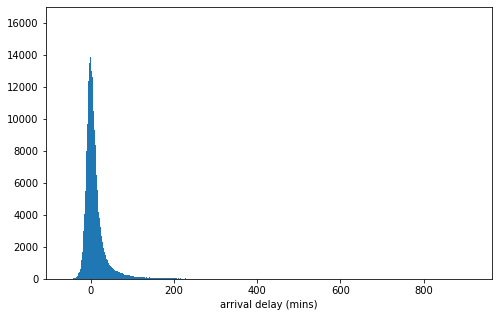

In [44]:
# begin with a histogram
bins = np.arange(df.arrdelay.min(), df.arrdelay.max() + 1, 1)
plt.figure(figsize=(8, 5))
plt.hist(df['arrdelay'], bins = bins)
plt.xlabel('arrival delay (mins)');
df.arrdelay.describe()

So the first histogram is difficult to read due to outliers. Although delays of this length are very possible, I'll check the maximum delay value to see if it's valid.

In [45]:
# see row for max arrdelay
df.iloc[df.arrdelay.argmax()]

year                       2002
month                  February
dayofmonth                    9
dayofweek              Saturday
deptime                07:51:00
crsdeptime             17:04:00
arrtime                09:22:00
crsarrtime             18:06:00
uniquecarrier                AA
flightnum                  1327
tailnum                  N504A1
actualelapsedtime         151.0
crselapsedtime            122.0
airtime                    90.0
arrdelay                  916.0
depdelay                  887.0
origin                      ATL
dest                        ORD
distance                  606.0
taxiin                      5.0
taxiout                    56.0
carrierdelay                NaN
weatherdelay                NaN
nasdelay                    NaN
securitydelay               NaN
lateaircraftdelay           NaN
date                 2002-02-09
Name: 296384, dtype: object

Everything looks correct. I suspect the other high values will be correct as well. Instead of dropping, etc., I'll zoom in on the histogram below to look at the bulk of the data.

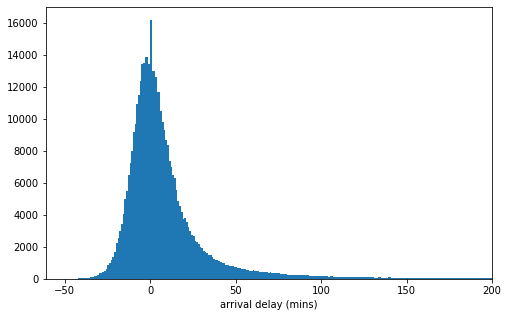

In [46]:
# plot histogram
plt.figure(figsize=(8, 5))
plt.hist(df['arrdelay'], bins = bins)
plt.xlabel('arrival delay (mins)');

# set x limits to zoom in 
plt.xlim(df.arrdelay.min() - 1, 200);

The distribution is unimodal, with most of the data concentrated close to zero. A significant portion of flights arrive ahead of schedule, but the data is right-skewed with a long tail. 



### Airports
Now I'll look at destination airports and origin airports. I'll start by seeing how many different airports appear in the dataset. I'll also see how many times Atlanta appears. 

In [47]:
# see how many different values for each variable
print(df.origin.nunique())
print(df.dest.nunique())


191
194


In [48]:
# see how many times ATL is origin and destination
print(df[df.origin == 'ATL'].shape[0])
print(df[df.dest == 'ATL'].shape[0])


215989
215388


I can't plot over 190 different values, so instead I'm going to pull the top 30 airports, excluding Atlanta. The above query shows that plotting with ATL as a value would lead to not seeing the other values in the plot.

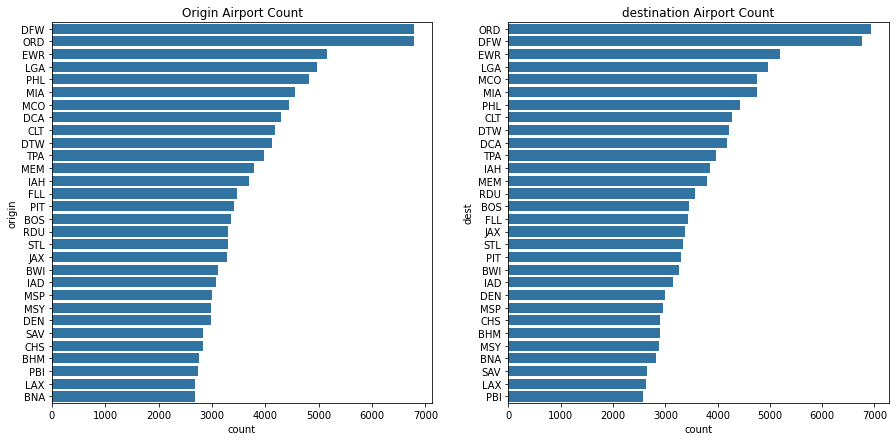

In [49]:
# make barplots to show count for each of top 30 airports for Dest and Origin

fig, ax = plt.subplots(1,2, figsize=(15, 7))
# get list of 30 airports that appear most in dataset, minus ATL(index 0)
origins = df.origin.value_counts()[1:31].index
destinations = df.dest.value_counts()[1:31].index

# create color for graphs
base_color = sb.color_palette()[0]

# plot barplots
sb.countplot(data = df[df.origin.isin(origins)], y = 'origin', order = origins,
             color = base_color, ax = ax[0])
sb.countplot(data = df[df.dest.isin(destinations)], y = 'dest', order = destinations,
             color = base_color, ax = ax[1]);
ax[0].title.set_text('Origin Airport Count')
ax[1].title.set_text('destination Airport Count');



In these top thirty airports for destination and origin, the lowest counts are at around 2600, and the highest close to 7000. The airports are the same in both, but the order is slightly different. The two most important airports, by far, are Dallas Fort Worth and Chicago O'hare.

Now I'll move onto day of the week and month. 
### Day of the Week and Month

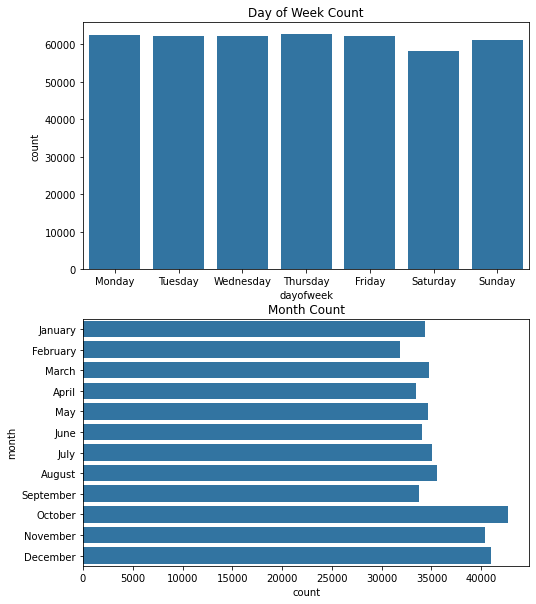

In [50]:
# make barplots to show count for day of week and month

fig, ax = plt.subplots(2,1, figsize=(8, 10))

sb.countplot(data = df, x = 'dayofweek',
             color = base_color, ax = ax[0])
sb.countplot(data = df, y = 'month',
             color = base_color, ax = ax[1]);

ax[0].set_title('Day of Week Count')
ax[1].set_title('Month Count');

All the days of the week are more or less equally respresented. There are slightly fewer flights on Saturday. 

The most respresented months are October, November and December. The latter two are because of holidays, I imagine, but October comes as a surprise.
### Distance
Finally, I'll take a look at distance, which I expect to be key in determining arrival delays.

count    431115.000000
mean        618.429665
std         446.088593
min          79.000000
25%         341.000000
50%         545.000000
75%         732.000000
max        4502.000000
Name: distance, dtype: float64

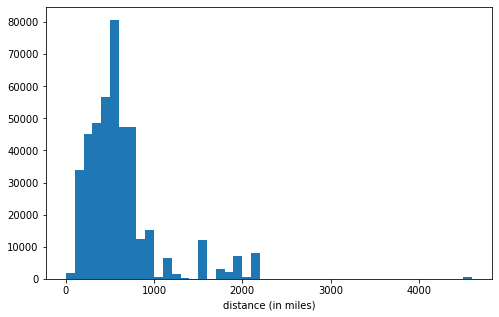

In [51]:
# plot a histogram of distance
plt.figure(figsize = (8,5))
bins = np.arange(0, df.distance.max() + 100, 100)
plt.hist(df.distance, bins = bins)
plt.xlabel('distance (in miles)');
df.distance.describe()

Unlike the other numeric variables, for distance, there are a fixed number of destinations, and the distance between them never changes. Most of the data is concentrated below 1000 miles from Atlanta, and above 1000, the bars starts to spread out. There is one outlier bar which I expect to be Hawaii. 

In [52]:
df[df.distance > 4000].dest.unique()

array(['ATL', 'HNL', 'OGG'], dtype=object)

HNL and OGG are Honolulu and Kahului airports, respectively. 

That is all for univariate exploration of the variables I expect to be most correlated with arrival delays. I will now check the distributions of the other variables I think could be interesting. 
### Departure Delay

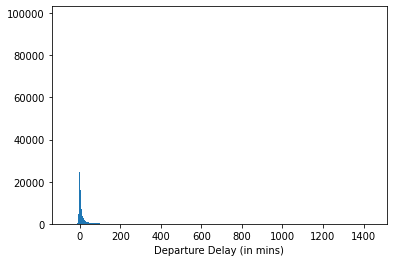

In [53]:
#plot histogram
bins = np.arange(df['depdelay'].min(), df['depdelay'].max() + 1, 1)
plt.hist(df.depdelay, bins = bins)
plt.xlabel('Departure Delay (in mins)');

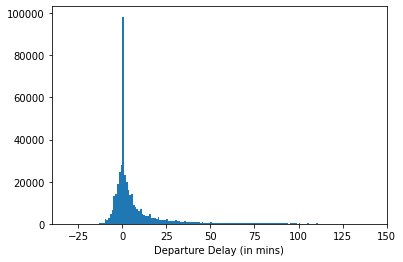

In [54]:
# plot histogram zoomed in with modified x limits
plt.hist(df.depdelay, bins = bins)
plt.xlim(-40, 150)
plt.xlabel('Departure Delay (in mins)');

It looks as if there are regular peaks in the data. I'll zoom in more by modifying the y limits to see.

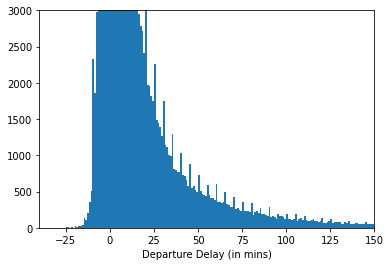

In [55]:
# plot histogram zoomed in with modified x and y limits

plt.hist(df.depdelay, bins = bins)
plt.xlim(-40, 150)
plt.ylim(0, 3000)
plt.xlabel('Departure Delay (in mins)');

Departure Delay will clearly be correlated to arrival delay to some degree. Late departures often end in late arrivals. For that reason, it might seem pointless to examine it in detail. However, looking at this variable will be interesting to see how often an arrival delay is the result of a departure delay and how often it is caused by something that happens after takeoff. 

The three histograms tell us a lot about this variable. First, an overwhelming amount of the points fall on zero. The data is right-skewed. Yet there are peaks at more or less every 5 minute increase. I don't think that departure delays are regularly divisible by 5. Perhaps this is a data entry error due to rounding off to the nearest five minutes? 
### Unique Carrier
Now I'll look at the counts for carriers going to and from ATL.

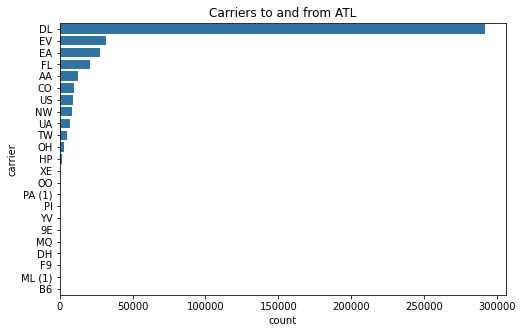

In [56]:
# get carriers in descending order
order = df.uniquecarrier.value_counts().index

# plot bar graph with counts
plt.figure(figsize = (8,5))
sb.countplot(data = df, y = 'uniquecarrier', order = order, color = base_color)
plt.ylabel('carrier')
plt.title('Carriers to and from ATL');

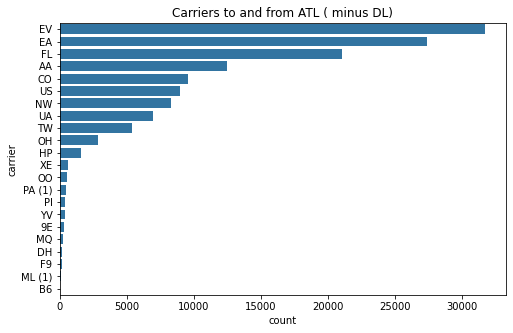

In [57]:
# zoom in on other carriers by plotting all carriers except DL
order = df[df.uniquecarrier != 'DL'].uniquecarrier.value_counts().index

plt.figure(figsize = (8,5))
sb.countplot(data = df[df.uniquecarrier != 'DL'], y = 'uniquecarrier', order = order, color = base_color)
plt.ylabel('carrier')
plt.title('Carriers to and from ATL ( minus DL)');

Unsurprisingly, Delta Airlines (DL) is the most frequent carrier in the dataset. The company is based out of Atlanta. When they are removed from the barplot, I can see that many other carriers represent a significant number of flights. Some carriers like B6, on the other hand, represent so few flights that I'll need to be wary of using them for any statistical analysis.
### Other Delay Columns
Lastly, I'll plot the other delay columns. Like departure delay, I expect them to be strongly correlated to arrival delay. examining them will tell me what type of delays are most common.

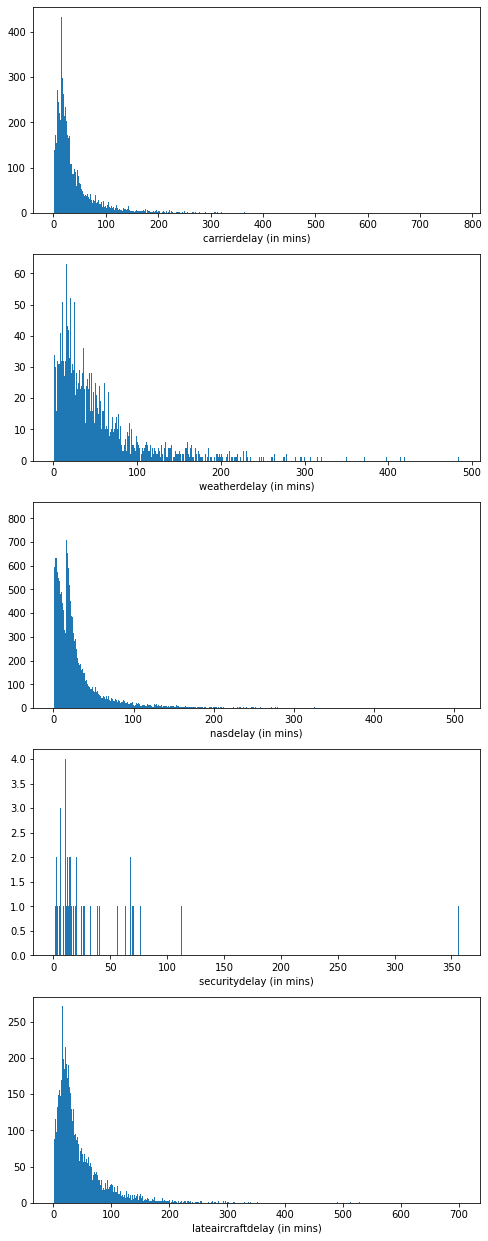

In [58]:
# make list of delay columns
delay_cols = ['carrierdelay','weatherdelay','nasdelay','securitydelay','lateaircraftdelay']

fig, ax = plt.subplots(5,1, figsize = [8,22])

# plot histogram of each delay column
for i in range(len(delay_cols)):
    var = delay_cols[i]
    bins = np.arange(0, df[var].max() + 1, 1)
    ax[i].hist(data = df, x = var, bins = bins)
    ax[i].set_xlabel('{}'.format(var + ' (in mins)'))

Almost all of the delay columns have a similar shape, unimodal and right skewed. The exceptions are nasdelay, which is bimodal and security delay, which is sparse due to few non-null points. Like with certain carriers, I'll need to be wary when looking at this variable. 
### Univariate Findings
The distribution of the variable of interest, arrival delay, was as expected. Right-skewed and unimodal, with most points congregated around 0. 

The other variables also had predictable distributions. The numeric variables had some outliers, but as I suspect they are all valid points, I simply zoomed in on the bulk of the data instead of dropping or modifying in any way. The categorical variables destination, origin, and unique carrier were dominated by Atlanta and Delta Airlines. In order to get a clearer picture of the counts, I removed these values from the barplots. 

Moving forward, it will be important to remember that certain carriers and airports represent very few datapoints. The column for security delay also has very few non-null values.

# Bivariate Exploration

I'll begin by checking the correlation of the numeric variables. 

In [59]:
# list of numeric variables of interest
numeric_vars = ['arrdelay','depdelay','airtime','distance','taxiin','taxiout','carrierdelay',
                'weatherdelay','nasdelay','securitydelay','lateaircraftdelay']

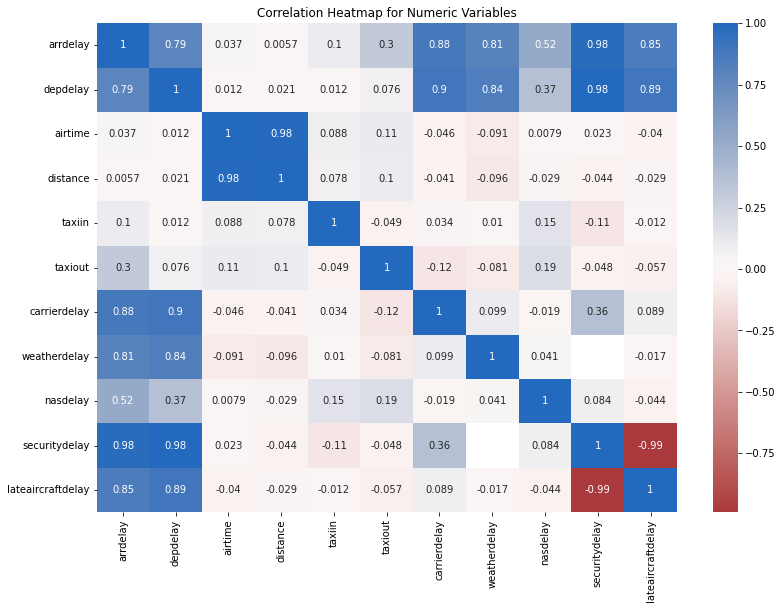

In [60]:
# plot correlation heatmap
plt.figure(figsize = (13,9))
sb.heatmap(df[numeric_vars].corr(),annot = True, cmap = 'vlag_r', center = 0)
plt.title('Correlation Heatmap for Numeric Variables');

The only variables that have a significant correlation are all of the delay columns against depdelay and arrdelay, and airtime against distance. This is not surprising. However, two things are interesting to note. The high correlation beteeen departure delay and arrival delay could imply that most late arrivals are caused by something that occurs *before* takeoff. The higher correlation of NAS delay against arrival delay than departure delay, however, goes against this line of thought. 

Distance and airtime are highly correlated, but this is obvious. Far-away destinations require more airtime. Contrary to my initial assumption, distance doesn't appear to have much influence on arrival delays or any other delay type, for that matter.

As for the high negative correlation between security and late aircraft, I believe it is due to the small number of security delay observations that aren't null, but I will do a quick check.

In [61]:
# check security delay against lateaircraftdelay
df[(~df.lateaircraftdelay.isnull()) & (~df.securitydelay.isnull())].shape[0]

3

The two variables only correspond on 3 rows, so comparing them is not informative. 

## Depdelay Against Arrdelay
I want to look into the relationship between depdelay and arrdelay, since they are so highly correlated.

Text(0, 0.5, 'Arrival Delay (in mins)')

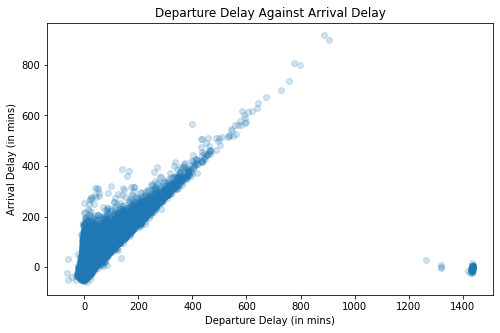

In [62]:
# scatterplot of depdelay vs arrdelay
plt.figure(figsize = (8,5))
plt.scatter(df.depdelay, df.arrdelay, alpha = 0.2)
plt.title('Departure Delay Against Arrival Delay')
plt.xlabel('Departure Delay (in mins)')
plt.ylabel('Arrival Delay (in mins)')

I see some outliers. It is hard to believe that a departure delay of almost 23 hours can cause no arrival delay. 

In [63]:
# see how many rows have high depdelay
df[df.depdelay > 1200].shape[0]

47

Since there are only 47 rows with such high depdelay, I'm going to drop them.

In [64]:
# get index for high depdelay and drop
bad_inx = df[df.depdelay > 1200].index
df.drop(bad_inx, axis = 0, inplace = True)

In [65]:
# recheck correlation between depdelay and arrdelay
df[['depdelay','arrdelay']].corr()

,depdelay,arrdelay
depdelay,1.000000,0.903204
arrdelay,0.903204,1.000000


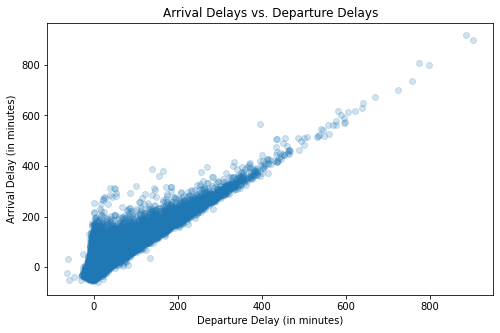

In [66]:
# replot scatterplot
plt.figure(figsize = (8,5))
plt.scatter(df.depdelay, df.arrdelay, alpha = 0.2)
plt.xlabel('Departure Delay (in minutes)')
plt.ylabel('Arrival Delay (in minutes)')
plt.title('Arrival Delays vs. Departure Delays');

The scatter plot has a very strong linear shape. This confirms my thought that most arrival delays are at least in part accompanied by a departure delay. However, there is a break in the linear pattern around where depdelay = 0. 

In [67]:
# look at rows where depdelay is zero and arrdelay is greater than 0
df[(df.depdelay == 0) & (df.arrdelay > 0)]

,year,month,dayofmonth,dayofweek,deptime,crsdeptime,arrtime,crsarrtime,uniquecarrier,flightnum,...,dest,distance,taxiin,taxiout,carrierdelay,weatherdelay,nasdelay,securitydelay,lateaircraftdelay,date
0,1987,October,1,Thursday,19:37:00,19:37:00,21:40:00,21:29:00,EA,734,...,ABE,692.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1987-10-01
2,1987,October,1,Thursday,06:44:00,06:44:00,07:41:00,07:40:00,DL,521,...,JAX,270.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1987-10-01
4,1987,October,1,Thursday,16:00:00,16:00:00,18:18:00,18:00:00,DL,1084,...,ATL,302.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1987-10-01
5,1987,October,1,Thursday,12:02:00,12:02:00,13:00:00,12:45:00,DL,616,...,ORD,606.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1987-10-01
7,1987,October,1,Thursday,08:20:00,08:20:00,15:56:00,15:43:00,DL,190,...,ATL,2182.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1987-10-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431294,2008,December,30,Tuesday,10:20:00,10:20:00,12:48:00,12:32:00,FL,368,...,LGA,761.0,5.0,31.0,NaN,NaN,16.0,NaN,NaN,2008-12-30
431304,2008,December,30,Tuesday,07:00:00,07:00:00,09:02:00,08:54:00,DL,1668,...,ATL,545.0,21.0,17.0,NaN,NaN,NaN,NaN,NaN,2008-12-30
431323,2008,December,30,Tuesday,16:31:00,16:31:00,19:35:00,19:08:00,EV,5134,...,ATL,552.0,23.0,20.0,NaN,NaN,27.0,NaN,NaN,2008-12-30
431331,2008,December,31,Wednesday,14:40:00,14:40:00,16:00:00,15:50:00,OH,6352,...,GSO,306.0,8.0,17.0,NaN,NaN,NaN,NaN,NaN,2008-12-31


Most of the delay columns are NaN for the subset. However, a few of the nasdelay columns are not. I'm going to take a look at the correlation heat map again, but for this subset of the data. 

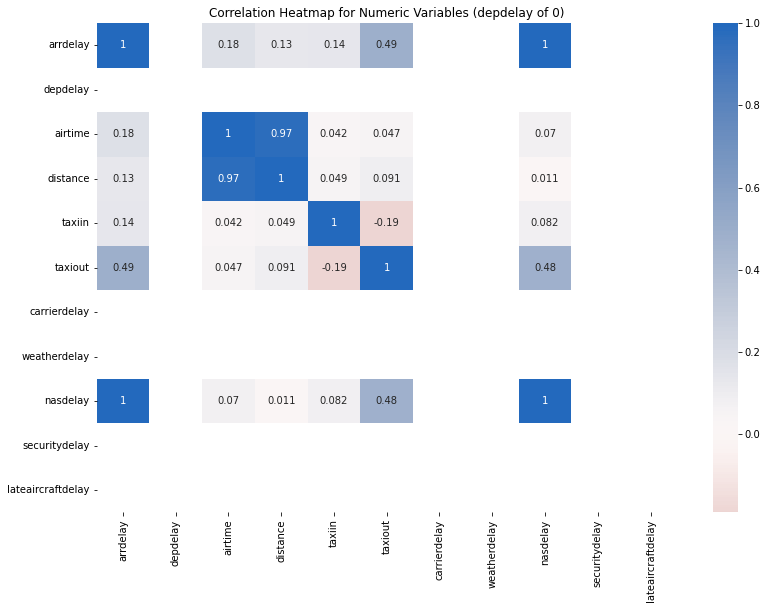

In [68]:
# create variable for subset where depdelay is 0 and arrdelay greater than 0 
zero_dep_delay = df[(df.depdelay == 0) & (df.arrdelay > 0)]
plt.figure(figsize = (13,9))

#plot correlation heatmap
sb.heatmap(zero_dep_delay[numeric_vars].corr(),annot = True, cmap = 'vlag_r', center = 0)
plt.title('Correlation Heatmap for Numeric Variables (depdelay of 0)');

When the departure delay is zero, the only type of delay that appears is NAS delay, and it has a 1.00 correlation with the arrival delay. I'll explore more in the multivariate section. 

This also explains in part the difference between correlation coefficients for departure delay/NAS delay and arrival delay/NAS delay. 

I'll leave this for now and move onto categorical variables. Since I've only selected flights from or to Atlanta, I'll look at how arrival delay correlates with having ATL as a destination or the origin.

## Atlanta as Origin vs. Atlanta as Destination

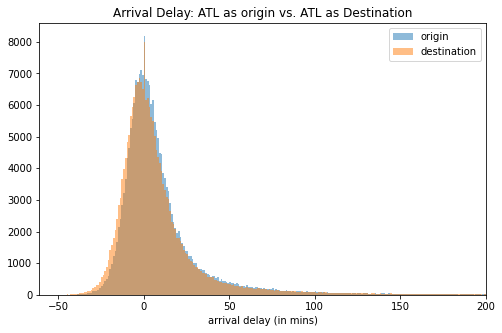

In [69]:
# create subsets with ATL as origin and destination
orig_atl_subset = df.query("origin == 'ATL'")
dest_atl_subset = df.query("dest == 'ATL'")

bins = np.arange(df.arrdelay.min(), df.arrdelay.max() + 1, 1)

# plot overlayed histogram of both subsets' arrdelay distribution
plt.figure(figsize = (8,5))
plt.hist(orig_atl_subset['arrdelay'], bins = bins, alpha = 0.5, label = 'origin')
plt.hist(dest_atl_subset['arrdelay'], bins = bins, alpha = 0.5, label = 'destination')
plt.legend()
plt.title('Arrival Delay: ATL as origin vs. ATL as Destination')
plt.xlabel('arrival delay (in mins)')

# recycle xlims from univariate histogram
plt.xlim(df.arrdelay.min() - 1, 200);

The two distributions are very similar. The distribution with ATL as origin is slightly more to the right than the destination distribution.

Nothing interesting here. I'm going to move on to day of the week and month against arrival delay.

## Day of Week Against Arrdelay

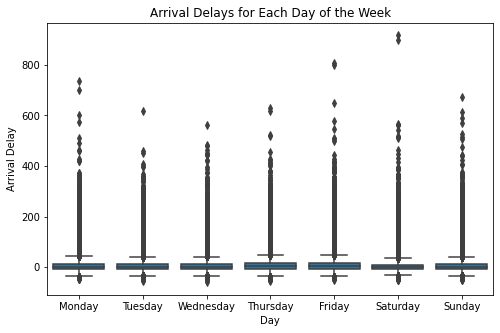

In [70]:
# plot a boxplot for weekdays 
plt.figure(figsize = (8,5))
sb.boxplot(data = df, y = 'arrdelay', x = 'dayofweek', color = base_color)
plt.title('Arrival Delays for Each Day of the Week')
plt.xlabel('Day')
plt.ylabel('Arrival Delay');

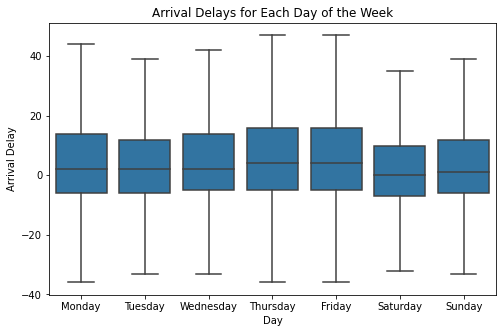

In [71]:
# remove outliers to see distribution more clearly
plt.figure(figsize = (8,5))
sb.boxplot(data = df, y = 'arrdelay', x = 'dayofweek', showfliers = False, color = base_color)
plt.title('Arrival Delays for Each Day of the Week')
plt.xlabel('Day')
plt.ylabel('Arrival Delay');

From the boxplot it seems Thursdays and Fridays tend to have higher arrival delays, and Saturdays have the lowest. But it doesn't seem to be a huge difference. I'm going to use a bivariate barplot to see the medians more clearly.

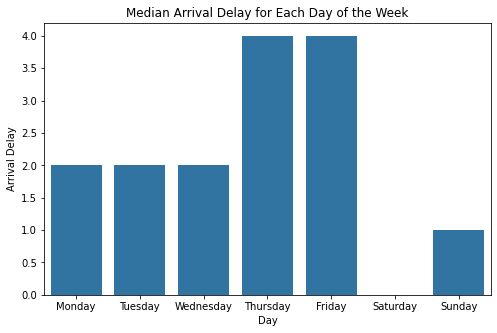

In [72]:
# plot barplot to see median arrdelay for weekdays
plt.figure(figsize = (8,5))

sb.barplot(data = df, y = 'arrdelay', x = 'dayofweek', estimator = np.median, color = base_color, errwidth = 0)
plt.title('Median Arrival Delay for Each Day of the Week')
plt.xlabel('Day')
plt.ylabel('Arrival Delay');

I've chosen to use the median because there are many outliers, and the distribution isn't symmetrical. 

The bar plot gives more clarity as to where the median is. Pracitcally, there is no significant difference between arrival times for certain days of the week. 

## Month against Arrdelay

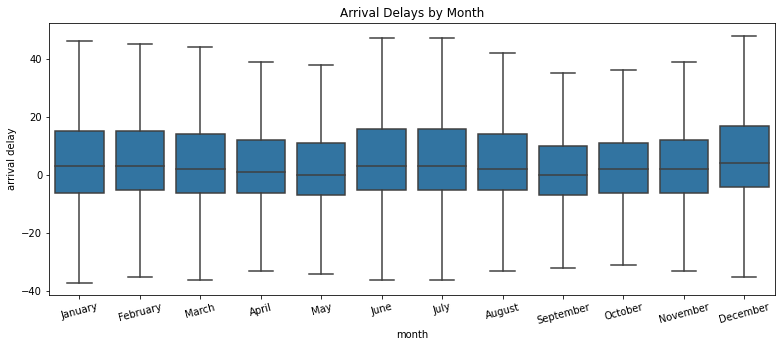

In [73]:
# plot boxplot to see distribution of arrdelay per month
plt.figure(figsize = ( 13, 5))
sb.boxplot(data = df, x = 'month', y = 'arrdelay', color = base_color, showfliers = False)
plt.xticks(rotation = 15)
plt.title('Arrival Delays by Month')
plt.ylabel('arrival delay');

The boxplot shows high delays in winter months as well as high delays in summer months. Delays in spring and fall are closer to zero. But like with days of the week, the difference does not appear to be significant. I'm going to view the medians with a barplot, like before. 

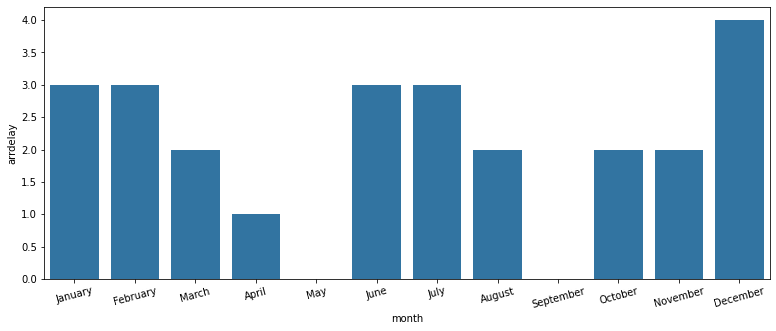

In [74]:
# plot barplot to zoom in on difference in median
plt.figure(figsize = ( 13, 5))
sb.barplot(data = df, x = 'month', y = 'arrdelay', color = base_color, estimator = np.median, errwidth = 0)
plt.xticks(rotation = 15);

There is not significant difference in median arrival delays between months. It would be interesting to see if there is a correlation between weather and the higher delays in winter months, as I suspect. Strangely, the other two months that stand out, June and July, are summer months. I know from the univariate plots that there is no significant difference in flight volume between months for this sample, so I would like to look into what that can be attributed to.

I'm going to use a heatmap, and get the counts of each type of delays, to see if one delay is more common for a certain month. Bearing in mind that this will only be for data after 2003, because I don't have the records for delay type before 2004. 

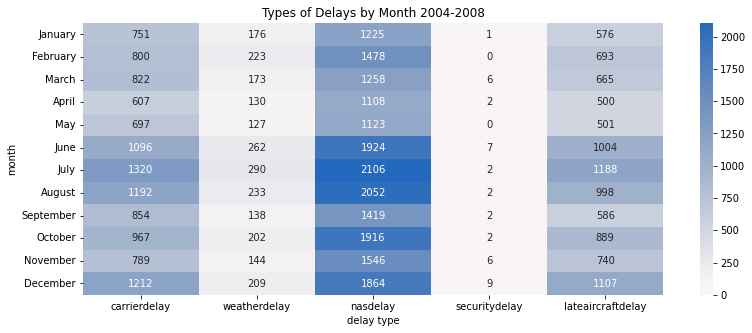

In [75]:
# groupby month and get count of each delay column
delay_counts = df.groupby('month').count()[delay_cols]

plt.figure(figsize = ( 13, 5))
#plot heatmap
sb.heatmap(delay_counts, annot = True, cmap = 'vlag_r', center = 0, fmt='g')
plt.title('Types of Delays by Month 2004-2008')
plt.xlabel('delay type');

It seems like for all the delay types except security where there is not enough data, there are lulls in spring and autumn and spikes in winter and summer. I was incorrect about weather and winter months though. There are surprisingly more weather delays in the summer months than in the winter months. 

## Airport Against Arrdelay
Now I want to see how different airports perform in terms of departure delay going to or from ATL. Given the number of airports, I will again get the top thirty in terms of total flights as destination and as origin(this time including ATL), and see the median arrival delay with a barplot.

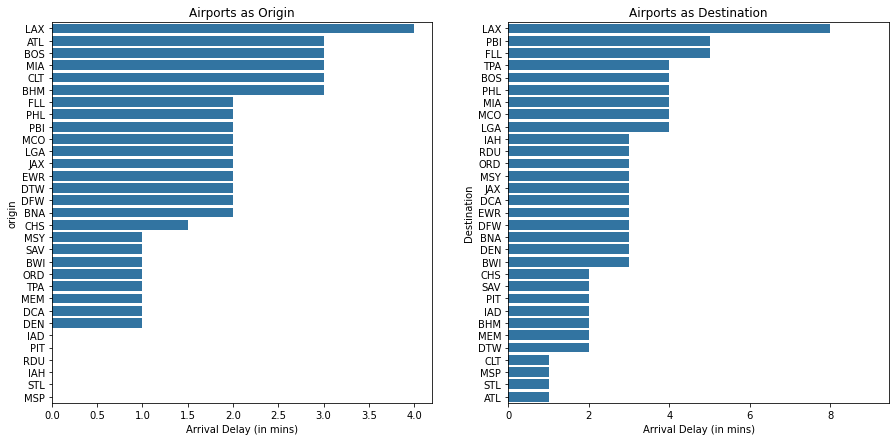

In [76]:
# one plot for destination and one for origin
fig, ax = plt.subplots(1,2, figsize = (15,7))

# get top 30 airports
all_origins = df.origin.value_counts()[:31].index
all_destinations = df.dest.value_counts()[:31].index

# get above airports ordered by median arrdelay in descending order
order1 = df[df.origin.isin(all_origins)].groupby('origin').median()['arrdelay'].sort_values(ascending = False).index
order2 = df[df.dest.isin(all_destinations)].groupby('dest').median()['arrdelay'].sort_values(ascending = False).index


# plot barplots 
sb.barplot(data = df[df.origin.isin(all_origins)], y = 'origin', x = 'arrdelay',
           color = base_color, order = order1, estimator = np.median, errwidth = 0, ax = ax[0])
ax[0].set_title('Airports as Origin')
ax[0].set_xlabel('Arrival Delay (in mins)')
sb.barplot(data = df[df.dest.isin(all_destinations)], y = 'dest', x = 'arrdelay',color = base_color,
           order = order2, estimator = np.median, errwidth = 0, ax = ax[1])
ax[1].set_title('Airports as Destination')
ax[1].set_xlabel('Arrival Delay (in mins)')
ax[1].set_ylabel('Destination');



For most airports, the difference in medians is not interesting. LAX tops the list both as origin and destination from ATL, however. And as a destination, it has a median arrdelay of 8 minutes, which is a higher than the other airports. I would like to explore this further in the multivariate section of my analysis. 

I'll now move onto the final categorical variable of interest, carrier.

## Unique Carrier against Arrdelay

<AxesSubplot:xlabel='arrdelay', ylabel='uniquecarrier'>

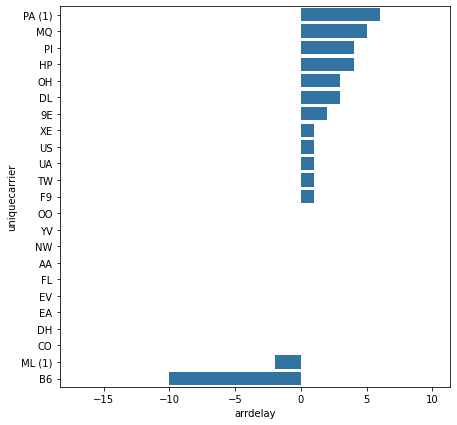

In [77]:
# get carriers by order of median arrival delay
order = df.groupby('uniquecarrier').median()['arrdelay'].sort_values(ascending = False).index

# plot barplot
plt.figure(figsize = (7, 7))
sb.barplot(data = df, y = 'uniquecarrier', x = 'arrdelay', order = order,
            errwidth = 0, color = base_color, estimator = np.median)

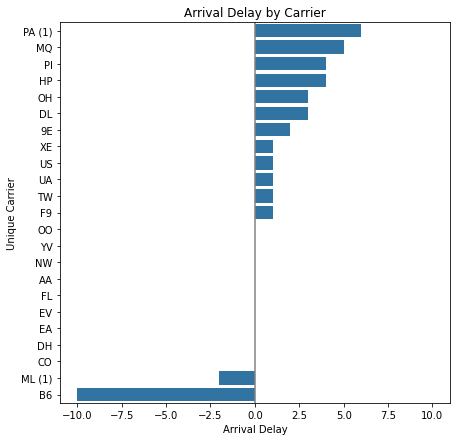

In [78]:
# replot above bar graph for better readability
plt.figure(figsize = (7, 7))
sb.barplot(data = df, y = 'uniquecarrier', x = 'arrdelay', order = order,
            errwidth = 0, color = base_color, estimator = np.median)


# add axvline on x = 0 for negative bar values
plt.axvline(x = 0, color = 'grey')
# xlims to zoom in 
plt.xlim(-11, 11)
plt.title('Arrival Delay by Carrier')
plt.xlabel('Arrival Delay')
plt.ylabel('Unique Carrier');

Like with months and days of the week, there are no significant differences in arrival delay across carriers. The exceptions are ML (Air Méditerranée) and B6 (JetBlue), which have negative values. However, I know from univariate plotting that these two airlines have a negligible amount of flights in the dataset, so it would not be interesting to investigate further. 

## Bivariate Findings
Many of the features did not have a strong correlation with Arrival delay, besides the different delay types, which is inevitable. It was intesting to see that departure delay has a very strong correlation with arrival delay, which means that many delays are in part affected by an event that happens before takeoff. In the event that there is an arrival delay but no departure delay, the only delay type that appears is NAS delay. 

There was also a surprising relationship between arrival delay and month. I expected higher delays in winter and was correct, but it seems delays are comparably high and more common in the summer months. 

Finally, although arrival delays between the different airports did not vary too much in general, there is a noticeably high median arrival delay to LAX as a destination from ATL. 



# Multivariate Exploration
In this section, I want to take a look at the most interesting relationships I found in the bivariate exploration, the relationship between departure delay and arrival delay, and LAX as a destination against arrival delay. 

## NAS, Departure and Arrival Delays
In the preivous section I noticed that NAS delays were the exclusive delays for arrival delays with a departure delay of 0. I would like to plot this relationship.

I'm going to make  a scatterplot and use color encodings to show which arrival delays have NAS delays and which do not for flights in the year 2004 and after, because before 2004 there is not data for delay type. 

To avoid overplotting, I'll use a sample of 1000 flights.




In [79]:
# make df of flights after 2003 so delay types are recorded
post_2003 = df.query("year > 2003")

# create column temp_delay_types and set default value to other
post_2003['temp_delay_types'] = 'other'

# set temp_delay_types to 'nas' where there is NAS delay
post_2003.loc[~post_2003.nasdelay.isnull(), 'temp_delay_types'] = 'NAS'

# where there is no delay stated, set temp_delay_types to 'not stated'
post_2003.loc[(post_2003.nasdelay.isnull()) & (post_2003.weatherdelay.isnull()) & (post_2003.lateaircraftdelay.isnull())
       & (post_2003.securitydelay.isnull()) & (post_2003.carrierdelay.isnull()), 'temp_delay_types'] = 'not stated'

/var/folders/gk/95gf3_y15dbfnfjxtd6m4dd40000gn/T/ipykernel_1951/1989522977.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_2003['temp_delay_types'] = 'other'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


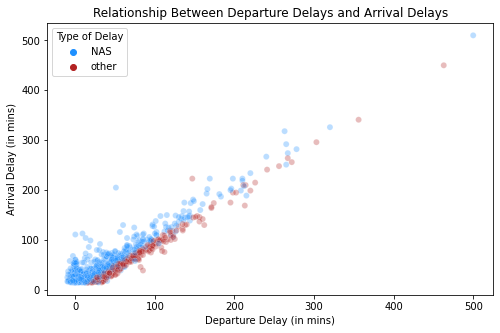

In [91]:
# get sample of 1000 flights where delay type IS stated
sample = post_2003[post_2003.temp_delay_types != 'not stated'].sample(1000)
colordict = {'nas': 'dodgerblue', 'other': 'firebrick'}
# plot scatterplot
plt.figure(figsize = (8,5))

colordict = {'NAS': 'dodgerblue', 'other': 'firebrick'}

sb.scatterplot(data = sample, x = 'depdelay', y = 'arrdelay', hue = 'temp_delay_types', alpha = 0.3, palette = colordict)
plt.xlabel('Departure Delay (in mins)')
plt.ylabel('Arrival Delay (in mins)')
plt.legend(title = 'Type of Delay')
plt.title('Relationship Between Departure Delays and Arrival Delays');

The above graph makes it clear that where there is no departure delay, the only delay type is NAS. It also seems that it accounts for many of the shorter departure delays, and generally results in a higher arrival delay.

When NAS delay is not present, the relationship between departure delay and arrival delay is more perfectly linear.

## LAX: Delay Types
To get a lead on different potential explanations for LAX's high median arrival delay, I would like to see if it has more of a certain type of delay, as compared to the entire dataset. Since there is a huge difference in size between a subset of LAX destination flights and the entire dataset, I'm going to look at the percentage of LAX destination delays that are of each type, and do the same for the entire dataset.

In [81]:
# get count of each delay type for LAX destination subset
lax_delay_counts = df[df.dest == 'LAX'].count()[delay_cols]

# get total number of delays
total_lax_del_counts = lax_delay_counts.sum()

# get percentages
lax_del_props = (lax_delay_counts / total_lax_del_counts) * 100

In [82]:
# reuse above process for entire dataset
delay_counts = df.count()[delay_cols]
total_delay_count = delay_counts.sum()
delay_props = (delay_counts / total_delay_count) * 100

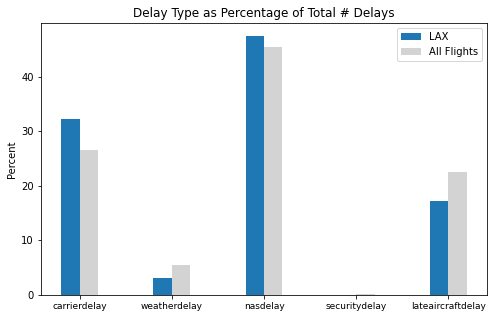

In [83]:
# plot clustered bar chart with percentages 
labels = delay_props.index

ind = np.arange(len(lax_del_props))
width = 0.2

plt.figure(figsize = (8,5))
lax_bar = plt.bar(ind,lax_del_props, width, label = 'LAX')
total_bar = plt.bar(ind + width, delay_props, width, label = 'All Flights', color = 'lightgrey')
locations = ind + width / 2 
plt.xticks(locations, labels,fontsize = 9)
plt.title('Delay Type as Percentage of Total # Delays')
plt.ylabel('Percent')
plt.legend();

Looking at the above graph, I see that LAX as a destination has a higher instance of carrier delays and NAS delays, but not by much. I know from the previous plot that NAS delays tend to cause longer arrival delays, so that could be contributing to its high arrival delays. Other than that, looking at how carrier and airport interact against arrival delay might be interesting to see what is happening at LAX. 

## Arrival Delay by Carrier for LAX vs. All Flights

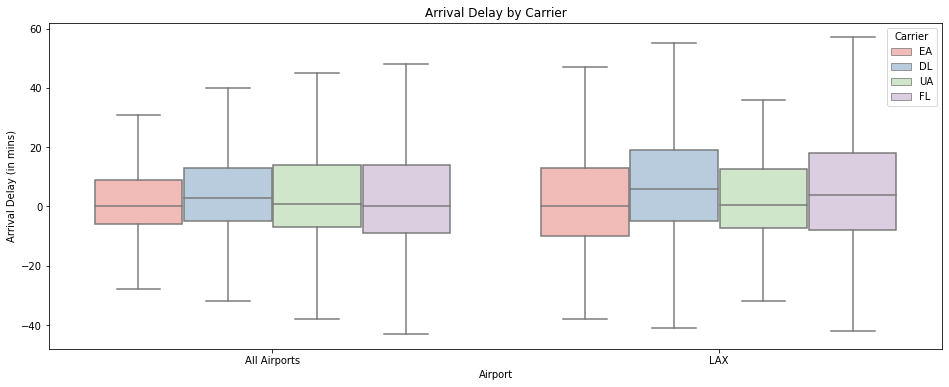

In [84]:
# create column to signal flights that have LAX as destination, set default to 'other airport'
df['lax_or_not'] = 'Other Airport'

# for flights with LAX as dest, set lax_or_not column value to 'LAX'
df.loc[(df['dest'] == 'LAX') | (df['origin'] == 'LAX'), 'lax_or_not'] = 'LAX'

# get list of carriers that serve ATL-LAX
laxcarriers = df[df.dest == 'LAX'].uniquecarrier.value_counts().index

# plot boxplot of Arrival delay by carrier 
plt.figure(figsize = (16, 6))
labels = ['All Airports','LAX']
sb.boxplot(data = df[df.uniquecarrier.isin(laxcarriers)],
           x = 'lax_or_not', y = 'arrdelay', hue = 'uniquecarrier', showfliers = False, palette = 'Pastel1');
plt.ylabel('Arrival Delay (in mins)')
plt.xlabel('Airport')
plt.title('Arrival Delay by Carrier')
plt.xticks(ticks = [0,1], labels = labels)
plt.legend(title = 'Carrier');

Three out of the four carriers that serve ATL-LAX have a five-number summary tending toward higher delays when LAX is the destination, as opposed to when the destination is any other airport in this dataset. I'll check the value counts for the carriers. I suspect that UA's performance at LAX looks better because it has relatively very few flights. 

In [85]:
# check carrier counts with destination LAX
df[df.dest == 'LAX'].uniquecarrier.value_counts()

DL    2308
FL     158
EA     141
UA      23
Name: uniquecarrier, dtype: int64

I was correct in the assumption. Since the trend seems to affect the three major carriers similarly, from the above graph I can only confirm that LAX generally has higher delays, which I already knew. 

## Arrival Delay For Destination Airports (LAX) by Season
Since I know that there is a difference in median arrival delay by month, I would like to see how months interact with airports, and LAX in particular, with respect to arrival delay. 

To avoid overplotting, I'm only going to look at destination airports with the highest median arrival delays, from the bivariate section. This will include LAX. 

Also, since I've seen that generally, summer and winter months have higher delays, I will group the months into seasons to reduce overplotting. 

In [86]:
# write function to get season for each month
def get_season(month):
    """ Take month name as string. Return corresponding season as string. """
    if month in ['December','January','February']:
        return 'winter'
    elif month in ['March','April','May']:
        return 'spring'
    elif month in ['June','July','August']:
        return 'summer'
    else:
        return 'fall'

In [87]:
# create season column with above function
df['season'] = df['month'].apply(lambda x: get_season(x))

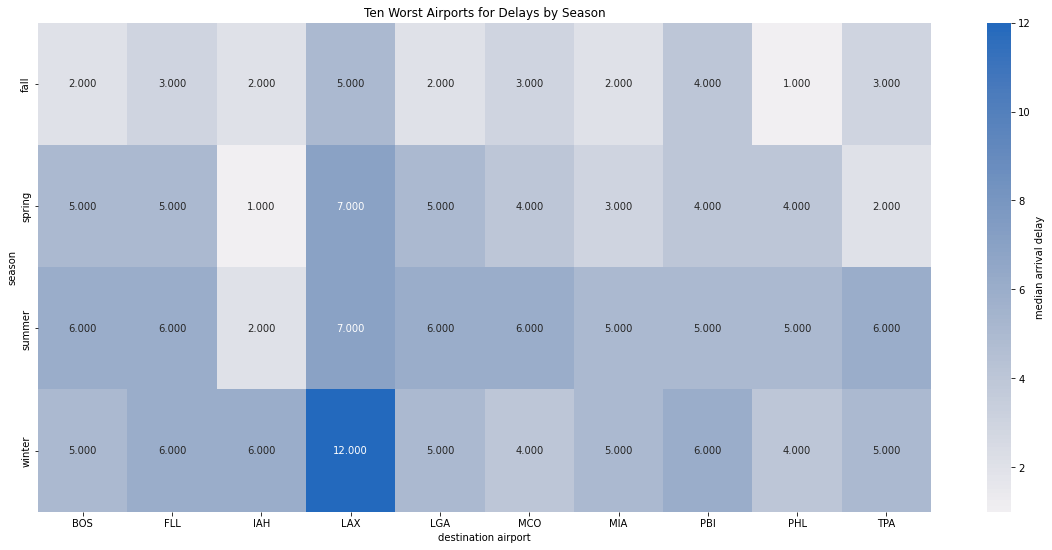

In [88]:

# reuse variable order2, get top ten airports with highest arrival delay median
dfdest = df[df.dest.isin(order2[:10])]

# get median grouped by dest and season columns, reform for heatmap
season_dest_medians = dfdest.groupby(['dest', 'season']).median()['arrdelay']
season_dest_medians = season_dest_medians.reset_index(name = 'arrdelay_median')
season_dest_medians = season_dest_medians.pivot(index = 'season', columns = 'dest',
                            values = 'arrdelay_median')

# plot heatmap 
plt.figure(figsize = (20, 9))
sb.heatmap(season_dest_medians, annot = True, fmt = '.3f',
           cbar_kws = {'label' : 'median arrival delay'}, cmap = 'vlag_r', center = 0)
plt.xlabel('destination airport')
plt.title('Ten Worst Airports for Delays by Season');

Although LAX generally has a higher median arrival delay than the other 9 airports, it spikes considerably in winter. For the other airports, the summer and winter months are almost equal. The airports generally follow the findings on month against arrival delay from the bivariate section. 

## Multivariate Findings
In this section, I confirmed the relationship between NAS delay and a departure delay of 0. It is the only recorded delay type for flights where this occurs. I also saw graphically that NAS delays generally result in higher arrival delays than other types.

I looked further into why LAX as a destination has such high arrival delays. I saw that it has a higher proportion of both carrier delays and NAS delays. The latter could in part explain the difference, as I observed that NAS delays are generally longer. I did not find any particular carrier that performed markedly worse when going to LAX from ATL, however. 

LAX also has a considerable spike in median arrival delay for the winter months compared to other airports I analyzed.

# Conclusions
Throughout my analysis of the Atlanta flights data, I searched for features that correlated strongly with arrival delay. I began with univariate analysis of the feature of interest and all other features I thought might be used to predict it. Knowledge of the distribution of each variable was useful for decision-making later in the analysis. I then moved on to bivariate exploration, focusing on how each variable interacted with arrival delay. Lastly, in the multivariate section of my analysis, I further investigated the strongest relationships I found in the bivariate section. 

At the beginning of analysis, my expectations were that distance, month and airport would be good predictors of arrival delay. In the end, distance had no correlation with arrival delay. Month of the year, on the other hand, *did* show an interesting pattern. The summer and winter months had slight spikes in median arrival delay, and counts of all the delay types grouped by month were highest in those months.

Arrival delay also varied by airport and whether or not the airport was origin or destination from ATL, although most of the airports I investigated(top 30 for highest median arrival delay) did not vary greatly. LAX did, however, so I investigated further in the multivariate section of analysis. Exploration there led me to conclude that in winter, median arrival delay at LAX as a destination from ATL spikes greatly compared to other airports with high delays. The airport as destination also suffers from a higher instance of NAS delays than the dataset at large. I found that these types of delays tend to result in longer arrival delays.

Beyond debunking or confirming my initial assumption, I also found that departure delay is strongly correlated with arrival delay, implying that many arrival delays are caused in part by a delay before takeoff. When there was no departure delay, the only delay type that appears is the NAS delay, for National Aviation System. According to the Bureau of Transportation Statistics (https://www.bts.gov/topics/airlines-and-airports/understanding-reporting-causes-flight-delays-and-cancellations accessed March 3, 2022), NAS delays can mean several different things, although non-severe weather problems represent a large percentage each year.

Finally, as this dataset only involves flights to and from Atlanta, I wanted to see if ATL had higher delays as a destination or an origin, and concluded that the distribution of arrival delays for the two are virtually the same. 

In [89]:
# save dataset with all engineered columns and with dropped rows from bivariate secion, to use in presentation
df.to_csv('POST_analysis_combined_atl_flights.csv', index = False)